# Домашняя работа. Решающие деревья и леса. kNN. SVM

## Общая информация

Дата выдачи: 22.08.2021

Срок сдачи: 05.09.2021 09:00MSK


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Обратите внимание, что только за реализацию функций без подтверждения их корректной работы оценка выставляться не будет.

Задание выполняется САМОСТОЯТЕЛЬНО. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 4 баллов.

При сдаче после указанного срока сдачи от выставленной оценки за работу будет отниматься 0.5 балла за каждые 24 часа просрочки.

### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: Username_hw9.ipynb, где Username — ваша фамилия на латинице (например, Kozlova_hw9.ipynb). Далее отправьте этот файл на почту pfilipovich@ibagroup.eu с темой письма "homework_09.%FULL_NAME%" с указанными выше условиями.

Заимпортим нужные библиотеки:

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import roc_auc_score
import pydotplus
# import pydot
# from sklearn import tree

## Постановка задачи

Давайте рассмотрим следующую задачу: зная информацию о пациенте попробуем предсказать есть ли у него сердечное заболевание. Каждый пациент будет описываться 13 признаками, включающими в себя возраст, пол, информацию из электрокардиограммы и т.д.

Загрузите данные из файла *heart.dat.txt*, используя пандас, в переменную *data* (разделитель полей — пробел). Значение целевой переменной находится в последней колонке (*Absence_(1)_or_presence_(2)_of_heart_disease*). 

In [2]:
data = pd.read_csv('heart.dat.txt', sep=' ')
data.head()

,age,sex,chest_pain_type,resting_blood_pressure,serum_cholestoral_in_mg/dl,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,the_slope_of_the_peak_exercise,number_of_major_vessels,thal,Absence_(1)_or_presence_(2)_of_heart_disease
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,0
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,0
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


Выделите признаки в переменную *X*, а целевую зависимость — в *y*.

In [3]:
target = 'Absence_(1)_or_presence_(2)_of_heart_disease'
X, y = data.drop(columns=[target]), data[target]

В начале рассмотрим решающее дерево. Как известно, одно дерево обладает плохой обобщающей сопособностью, поэтому стоит подбирать параметры, такие как высота дерева и минимальное число объектов в листе, для уменьшения этого явления.

Для оценки качества будем использовать 5-Fold кросс-валидацию с метрикой *AUC-ROC*. Создайте объект [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html) со следующими параметрами:
 - первым параметром нужно передать количество объектов в выборке
 - *n_folds* равно 5
 - установить *shuffle=True*, чтобы объекты были перемешаны перед разбиением
 - зафиксировать *random_state*

In [4]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

Теперь воспользуемся функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) для оценки качества. Она принимает следующие параметры:
 - *estimator* — в данном случае им будет решающее дерево [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Здесь и далее фиксируйте параметр *random_state* у решающего дерева, чтобы результат был воспроизводим. В этом пункте ограничения на другие параметры не накладываются
 - *X* и *y* — матрица "объект-признак" и значение целевой переменной соответственно
 - *scoring* просто указать *roc_auc_score*
 - *cv* — передать созданный ранее kfold
 
Эта функция возвращает массив значений качества на каждом разбиении. 

Опционарно использовать [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) для перебора признаков - в дополнение к перебору комбинаций признаков руками.

**(1 балл)** Посчитайте среднее, минимальное и максимальное качество, которое получатеся с помощью решающего дерева.

In [5]:
results = cross_val_score(DecisionTreeClassifier(random_state=1), X, y, scoring='roc_auc', cv=kfold)
print('min =', results.min(), '\nmax =', results.max(), '\nmean =', results.mean())

min = 0.697054698457223 
max = 0.798076923076923 
mean = 0.7679706213890573


**(0.5 балла)** Теперь попробуем посмотреть изменится ли оно, если ограничить высоту дерева. Зафиксируйте высоту дерева равной 3 и повторите аналогичные действия. Увеличились ли показания качества по сравнению с прошлым разом?

**Дополнительно: отобразите дерево с помощью graphviz. Можно использовать `pydot` или, например, [онлайн-сервис](https://www.coolutils.com/ru/online/DOT-to-PNG) dot2png.**

In [6]:
tree3 = DecisionTreeClassifier(random_state=1, max_depth=3)
results = cross_val_score(tree3, X, y, scoring='roc_auc', cv=kfold)
print('min =', results.min(), '\nmax =', results.max(), '\nmean =', results.mean())

min = 0.7328190743338008 
max = 0.9017857142857142 
mean = 0.8322307131026239


Ограничение высоты дерева повысила качество предсказаний!

In [7]:
def visualize_tree(tree_model, X, y):
    tree_model.fit(X, y)
    out_file = export_graphviz(
        tree_model,
        feature_names=X.columns,
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(out_file)
    return Image(graph.create_png())

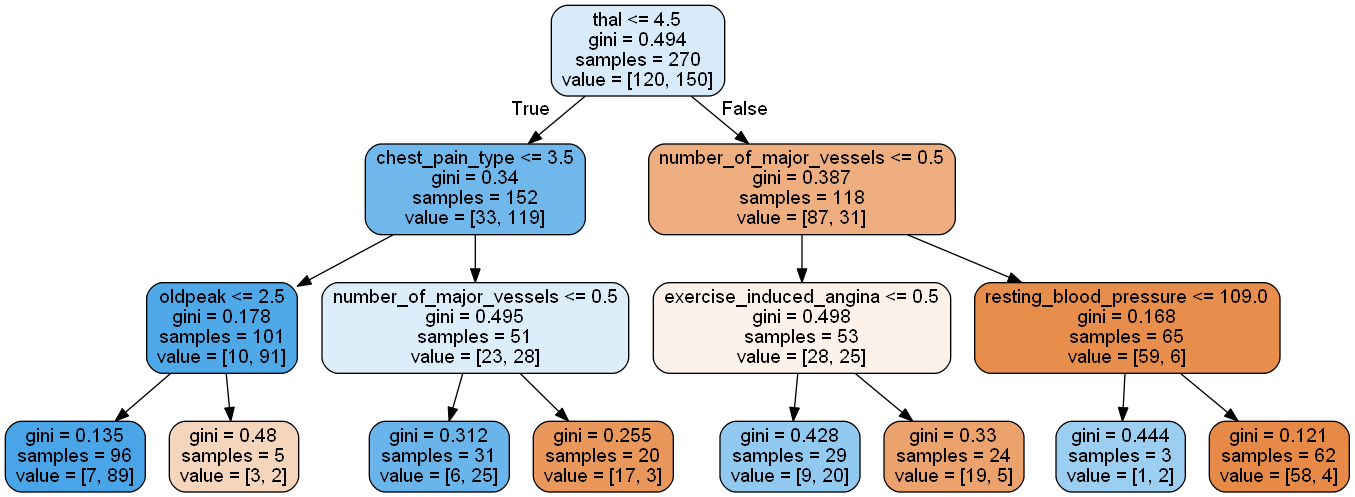

In [8]:
visualize_tree(tree3, X, y)

**(0.5 балла)** А принесет ли улучшение, если ограничить высоту дерева 1? 

**Дополнительно: отобразите дерево с помощью graphviz. Можно использовать `pydot` или, например, [онлайн-сервис](https://www.coolutils.com/ru/online/DOT-to-PNG) dot2png.**

In [9]:
tree1 = DecisionTreeClassifier(random_state=1, max_depth=1)
results = cross_val_score(tree1, X, y, scoring='roc_auc', cv=kfold)
print('min =', results.min(), '\nmax =', results.max(), '\nmean =', results.mean())

min = 0.6430575035063113 
max = 0.7710344827586206 
mean = 0.7141744664711247


А вот пень показывает худший результат среди этих трех моделей.

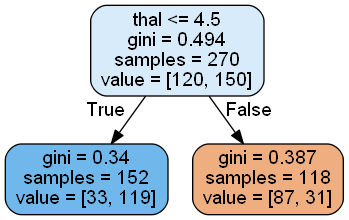

In [10]:
visualize_tree(tree1, X, y)

**(1 балл)** Напишите почему наложение ограничения на высоту дерева влияет на его обобщающую способность. Почему деревья глубиной 1 по одиночке могут быть неэффективны?

Без ограничений на высоту дерево делает split'ы до тех пор, пока мера неоднородности не даст значение 0. Но в таком случае оно подстраивается под каждый выброс и сильно переобучается. Наложение ограничения на высоту позволяет не учитывать отдельные выбросы, поэтому модель будет лучше обобщать и будет показывать лучшие результаты на тестовой выборке (но может так получиться, что в листе неоднородность будет слишком большой и дерево не доучится). Дерево глубиной 1 по сути принимает решение, исходя лишь из одного признака и одного threshold'a, поэтому оно может быть неэффективно.

**(2 балла)** Теперь попробуем провести аналогичные эксперименты для случая решающего леса [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Рассмотрите 10, 50 и 100 деревьев в случайном лесу (поле *n_estimators*) для высоты деревьев по умолчанию, 3 и 1 (поле *max_depth*). Не забудьте зафиксировать *random_state*. Улучшается ли качество при увеличении количества деревьев в лесу? Сильно ли влияет ограничение на высоту деревьев при построении леса?

In [11]:
n_ests = [10, 50, 100]
depths = [1, 3, None]
rf_table = pd.DataFrame(np.ones(shape=[3, 3]), columns=depths, index=n_ests)

for n_est in n_ests:
    for depth in depths:
        model = RandomForestClassifier(random_state=1, n_estimators=n_est, max_depth=depth)
        results = cross_val_score(model, X, y, scoring='roc_auc', cv=kfold)
        rf_table.loc[n_est, depth] = results.mean()
rf_table.columns = ['1', '3', 'No limit']
        
print('Зависимость качества RandomForestClassifier от высоты(колонки) и числа деревьев(строки).')
rf_table

Зависимость качества RandomForestClassifier от высоты(колонки) и числа деревьев(строки).


,1,3,No limit
10,0.853394,0.907802,0.884197
50,0.900808,0.912705,0.911652
100,0.902312,0.917144,0.916541


Как видно из таблицы, качество модели повышается при увеличении количества деревьев. 
Без ограничений на высоту качество модели понизилось, но совсем не сильно (RandomForest реализует бэггинг, и поэтому достаточно устойчив к переобучению деревьев, ведь переобученные деревья дают наименее скоррелированные ошибки, а в основе доказательства улучшенной оценки семейства деревьев по сравнению с одиночными как раз и лежит предположение, что ошибки деревьев независимы).

**(1 балл)** И напоследок посмотрим, какие признаки являются наиболее *важными*. Обучите решающий лес с оптимальными на ваш взгляд параметрами (можете опираться на эксперименты ранее) на всей выборке и посмотрите на поле *feature\_importances\_* у обученного леса. Выпишите названия наиболее и наименее важных признаков с точки зрения случайного леса. 

In [12]:
optimal_tree = RandomForestClassifier(random_state=1, n_estimators=100, max_depth=3)
optimal_tree.fit(X, y)
importences = pd.Series(optimal_tree.feature_importances_, index=X.columns).sort_values(ascending=False)
importences

thal                                    0.215216
chest_pain_type                         0.187060
number_of_major_vessels                 0.145033
maximum_heart_rate_achieved             0.107710
oldpeak                                 0.087640
the_slope_of_the_peak_exercise          0.061885
exercise_induced_angina                 0.050343
age                                     0.041035
resting_blood_pressure                  0.033559
serum_cholestoral_in_mg/dl              0.032127
sex                                     0.027490
resting_electrocardiographic_results    0.008916
fasting_blood_sugar                     0.001986
dtype: float64

Наиболее значимыми признаками является thal рейтинг и тип боли в груди, наименее - fasting_blood_sugar, resting_electrocardiographic_results.

**(2 балла)** Попробуем провести аналогичные эксперименты для kNN [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). Рассмотрите не менее 5-х различных N (поле *n_neighbors*, обязательно включая [1, 5, 21]), попробуйте изменять функцию (не менее 3-х) для определения расстояния в пространстве (поле *metric*). Как влияет количество соседей на получаемый результат? Каким образом подбирали остальные величины количества соседей? Как влияние функции определения расстояния в пространстве?

In [13]:
ks = [1, 5, 21, 23, 27]
metrics = ['euclidean', 'manhattan', 'chebyshev']
knn_table = pd.DataFrame(np.ones([len(ks), len(metrics)]), columns=metrics, index=ks)

for k in ks:
    for metric in metrics:
        knc = KNeighborsClassifier(n_neighbors=k, metric=metric)
        results = cross_val_score(knc, X, y, scoring='roc_auc', cv=kfold)
        knn_table.loc[k, metric] = results.mean()
        # print(f'k={k}, metric={metric}: {results.mean()}')
  
print('Зависимость качества KNeighborsClassifier от метрики(колонки) и k(строки).')
knn_table

Зависимость качества KNeighborsClassifier от метрики(колонки) и k(строки).


,euclidean,manhattan,chebyshev
1,0.585584,0.649704,0.589724
5,0.724068,0.768398,0.707851
21,0.757950,0.807877,0.714650
23,0.751163,0.810021,0.717349
27,0.752593,0.797687,0.725297


Слишком большой k будет предсказывать слишком обобщенно, а модель со слишком маленьким k будет чувствительна к выбросам.
В данном случае модель показала лучшие результаты среди [1, 5, 21] на k=21 на всех метриках, а 23 и 27 рассматривались, т.к. при k=23 модель для большинства метрик показывает лучшие результаты по сравнению с 21, а вот k=27 в большинстве случаев уже проигрывает k=21. Для данной задачи Manhattan metric подошла лучше остальных.

**(2 балла)** Попробуем провести аналогичные эксперименты для SVM [SVC (Support Vector Classifier)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). Рассмотрите различные ядра (поле *kernel*, [linear, poly, rbf, sigmoid]), для [poly] попробуйте разные степени полинома, не менее 4 (поле *degree*, обязательно попробуйте [1,3]). Как влияют разные ядра на получаемый результат? Как влияет степень полинома на результат?

In [14]:
kernels = ['linear', 'rbf', 'sigmoid']
for kernel in kernels:
    svc = SVC(kernel=kernel)
    results = cross_val_score(svc, X, y, scoring='roc_auc', cv=kfold)
    print(f'kernel={kernel}: {results.mean()}')

poly_degrees = [1, 3, 10, 15, 20]
for degree in poly_degrees:
    svc = SVC(kernel='poly', degree=degree)
    results = cross_val_score(svc, X, y, scoring='roc_auc', cv=kfold)
    print(f'kernel=poly, degree={degree}: {results.mean()}')

kernel=linear: 0.9130928399678219
kernel=rbf: 0.7637118859334364
kernel=sigmoid: 0.7062215384095735
kernel=poly, degree=1: 0.7596356557039925
kernel=poly, degree=3: 0.7628874311514926
kernel=poly, degree=10: 0.8143796243789957
kernel=poly, degree=15: 0.802841817895259
kernel=poly, degree=20: 0.7957134372078996


В нашем случае наиболее высокие результаты показало ядро  linear. В случае poly, сначала с повышением степени точность предсказания сначала повышается (при 10 максимальна для данного набора степеней), а затем снижается.

### Бонусная задача

Самостоятельно реализуйте DecisionTree с некоторыми ограничениями (перечислены ниже). Задание может быть оценено частично.

Он должен получать на вход матрицу объект-признак и целевую переменную. На каждом этапе должен производить определение оптимальной пары признак-величина (для создания разделения данных, поступавших в вершину). Ограничение обучения реализуйте через ограничение допустимой максимальной глубины дерева - остальные опционарно.

В качестве данных предлагается использовать игрушечный датасет из курса ODS.

**Рассмотрим игрушечную задачу бинарной классификации: поедет ли с Вами новый знакомый из бара? Это будет зависеть от Вашей внешности и красноречия, крепости предлагаемых напитков и, как это ни меркантильно, от количества потраченных в баре денег.**

### Создание набора данных

In [15]:
from sklearn.preprocessing import LabelEncoder

# Создание датафрейма с dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [16]:
features = ['Внешность', 'Алкоголь_в_напитке',
            'Уровень_красноречия', 'Потраченные_деньги']
target = ['Поедет']

**Обучающая выборка**

In [17]:
df_train = {}
df_train['Внешность'] = ['приятная', 'приятная', 'приятная', 'отталкивающая',
                         'отталкивающая', 'отталкивающая', 'приятная'] 
df_train['Алкоголь_в_напитке'] = ['да', 'да', 'нет', 'нет', 'да', 'да', 'да']
df_train['Уровень_красноречия'] = ['высокий', 'низкий', 'средний', 'средний', 'низкий',
                                   'высокий', 'средний']
df_train['Потраченные_деньги'] = ['много', 'мало', 'много', 'мало', 'много',
                                  'много', 'много']
df_train['Поедет'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Поедет,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_низкий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,0,1,1,0,1,0,0,0,1
1,1,0,1,1,0,0,1,0,1,0
2,0,0,1,0,1,0,0,1,0,1
3,1,1,0,0,1,0,0,1,1,0
4,1,1,0,1,0,0,1,0,0,1
5,0,1,0,1,0,1,0,0,0,1
6,0,0,1,1,0,0,0,1,0,1


**Тестовая выборка**

In [18]:
df_test = {}
df_test['Внешность'] = ['приятная', 'приятная', 'отталкивающая'] 
df_test['Алкоголь_в_напитке'] = ['нет', 'да', 'да']
df_test['Уровень_красноречия'] = ['средний', 'высокий', 'средний']
df_test['Потраченные_деньги'] = ['много', 'мало', 'много']
df_test = create_df(df_test, features)
df_test

,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,1,0,1,0,1,0,1
1,0,1,1,0,1,0,1,0
2,1,0,1,0,0,1,0,1


In [19]:
# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
y = df_train['Поедет']
df_train, df_test = intersect_features(train=df_train, test=df_test)

df_train

,Потраченные_деньги_мало,Алкоголь_в_напитке_нет,Потраченные_деньги_много,Уровень_красноречия_средний,Внешность_приятная,Внешность_отталкивающая,Уровень_красноречия_высокий,Алкоголь_в_напитке_да
0,0,0,1,0,1,0,1,1
1,1,0,0,0,1,0,0,1
2,0,1,1,1,1,0,0,0
3,1,1,0,1,0,1,0,0
4,0,0,1,0,0,1,0,1
5,0,0,1,0,0,1,1,1
6,0,0,1,1,1,0,0,1


In [20]:
df_test

,Потраченные_деньги_мало,Алкоголь_в_напитке_нет,Потраченные_деньги_много,Уровень_красноречия_средний,Внешность_приятная,Внешность_отталкивающая,Уровень_красноречия_высокий,Алкоголь_в_напитке_да
0,0,1,1,1,1,0,0,0
1,1,0,0,0,1,0,1,1
2,0,0,1,1,0,1,0,1


Для облегчения рекомендуется использовать (и реализовать) функции приведённые ниже.

In [21]:
# расчёт энтропии множества

def entropy(a_list):
    '''Return Entropy of the list.'''
    arr, n = np.array(a_list), len(a_list)
    entr = 0
    for _, freq in zip(*(np.unique(arr, return_counts=True))):
        p = freq / n
        entr += p * np.log(p) 
    return -entr

In [22]:
# расчет прироста информации

def information_gain(root, left, right):
    ''' root - изначальный набор данных, left и right два разбиения изначального набора'''
    n, l, r = len(root), len(left), len(right)
    return entropy(root) - ((l/n)*entropy(left) + (r/n)*entropy(right))

In [23]:
# определение оптимального разбиения с точки зрения прироста информации

def best_feature_to_split(X, y):
    '''Return best feature to split by.'''
    max_gain = -np.inf
    best_feature = None
    for feature in X.columns:
        gain = information_gain(y, y[X[feature] == 1], y[X[feature] == 0])
        if gain > max_gain:
            max_gain = gain
            best_feature = feature
    return best_feature

In [24]:

def count_leaf_value(y):
    y_ = y[y == 1]
    sum_ = y_.sum() if (len(y_) > 0) else 0
    return round(sum_ / len(y))

def build(i, X, y, nodes): 
    '''
    Build a decision tree recursively.
    
    Parameters
    ----------
    i : int
        Current nodes' index
    X : pd.DataFrame
    y : pd.Series
        Target column for X
    nodes : list
        List of tree's nodes
    '''
    
    # if i is not a leaf
    if i < (len(nodes)//2):
        feature = best_feature_to_split(X, y)
        mask = (X[feature] == 1)
        
        # if Entropy is not zero
        if not ((mask.sum() == len(mask)) | (mask.sum() == 0)):
            nodes[i] = [False, feature] # 'False' means not a leaf
            build(2*i+1, X[mask], y[mask], nodes)
            build(2*i+2, X[(~mask)], y[(~mask)], nodes)
            
        # Entropy is zero - can stop splitting
        else: 
            nodes[i] = [True, count_leaf_value(y)]
        
    # max_depth reached
    else:
        nodes[i] = [True, count_leaf_value(y)]


def pred(row, i, nodes):
    '''
    Search for a prediction in a tree recursively.
    
    Parameters
    ----------
    row : pd.Series
        Row to make a prediction to
    i : int
        Current nodes' index
    nodes : list
        List of fitted tree's nodes
    '''
    # if we can split
    if not nodes[i][0]:
        feature = nodes[i][1]
        if row[feature]:
            return pred(row, 2*i+1, nodes)
        else:
            return pred(row, 2*i+2, nodes)
        
    # if the node is a leaf
    else:
        return nodes[i][1]

In [25]:
class DecisionTree:
    
    def __init__(self, max_depth=3):
        self.max_depth=max_depth
        # tree nodes are stored in an array
        # (i)'s children are (2i) and (2i+1)
        self.nodes = [0 for _ in range(2**(max_depth+1) - 1)]
    
    def fit(self, X, y):
        build(0, X, y, self.nodes)
    
    def predict(self, X):
        return X.apply(lambda row: pred(row, 0, self.nodes), axis=1)

In [26]:
tree_object = DecisionTree()

In [27]:
tree_object.fit(df_train, y)

In [28]:
tree_object.predict(df_test)

0    0
1    1
2    1
dtype: int64

Посмотрим, что предскажет эта же модель из библиотеки sklearn:

In [29]:
dtree = DecisionTreeClassifier(max_depth=3)
dtree.fit(df_train, y)
dtree.predict(df_test)

array([0, 1, 1], dtype=int64)

Вау, да это же то же самое, что и моя!